In [19]:
using PyPlot

Qt: Untested Windows version 10.0 detected!
INFO: Loading help data...


In [1]:
include("sim.jl"); #include the simulator 
include("floopMap.jl") #include mapping

Import successful: sim.jl
Import successful: floopMap.jl


In [2]:
nSeg=5 #number of segments
aStep=3 #angle step 
aLimit=60
res=10 #resolution of segment 
l=1/res #set subsegment lenght so that segment lenght =1


0.1

In [70]:
### Begin continuous state space code
# s: 5 element column vector of joint angles
# a: 5 element column vector of action on each segment -> currently a[i] ∈ {-1, 0, 1}
# w: currently 9 element column vector of weights for value approximation

BasisSize = 9

global GoalPos, GoalThresh
GoalPos = [4.5,1]
GoalThresh = 0.3
goal=Zone(GoalPos', GoalThresh) #create zone object for goal 

Zone([4.5,1.0],0.3)

In [71]:
drawZone(goal)

LoadError: dimensions must match
while loading In[71], in expression starting on line 1

In [13]:
function ContReward(s)
    
    eDec = 2 # exponential decay factor in the goal proximity
    
    EEpos = ccEnd(s)
    goalDist = norm(GoalPos - EEpos')
    
    (goalDist < GoalThresh) ? r = 1000 : r = 0
    #(goalDist < GoalThresh) ? r = 1000 : r = exp(-eDec*goalDist) # if within threshold of goal, return full reward. Otherwise, return negative exponential of distance to goal
    return r
end

ContReward (generic function with 1 method)

In [12]:
function ContTrans(s,a)
    #currently deterministic, finite action space
    return s + a #can make this probabilistic by sampling from distribution
end

ContTrans (generic function with 1 method)

In [6]:
function ValApprox(w, s)
    # features: EEpos, goalDist, s, const. (currently 10 elements) -> add ObstDist when obstacles added. And other bases?
    return sum(w.*BasisFun(s))
end

ValApprox (generic function with 1 method)

In [11]:
function BasisFun(s)
    
    #EEpos = ccQuick(s, 1)[end,:]
    EEpos = ccEnd(s)
    goalDist = norm(GoalPos' - EEpos)
    return [EEpos'; goalDist; s'; 1]
    
end

BasisFun (generic function with 1 method)

In [45]:
m = 1000 # number of state samples
w = zeros(BasisSize) #initialize weights
aSize = 243 #number of possible actions
kMax = 1 # number of samples of probabilistic transition - currently 1 because deterministic transition
γ = 0.95 # learning rate
y = zeros(m)
action = [0 0 0 0 0]
#println(size(w))
#println(size(action))

stateMat = zeros(m,5)
for i = 1:m # set up this way so can change state initialization based on trajectory following
    stateMat[i, :] = [rand(-90:90) rand(-90:90) rand(-90:90) rand(-90:90) rand(-90:90)]
end

for iters = 1:50
    tic()
    A = zeros(m,BasisSize)

    for i = 1:m
    
        q = zeros(aSize)
        state = stateMat[i,:]
        A[i,:] = BasisFun(state)

        for j = 1:aSize
            action[1],action[2],action[3],action[4],action[5] = ind2sub((3,3,3,3,3),j)
            action -=2
            for k = 1:kMax
                #println(ContReward(state))
                #println(ValApprox(w,ContTrans(state,action)))
                #println(w)
                q[j] += (ContReward(state) + γ*ValApprox(w,ContTrans(state,action)))/kMax
                #println("ok")
            end
        end

        y[i] = maximum(q)
    
    end

    wp = (pinv(A)*y)
    println(norm(wp - w))
    w = wp
    toc()
end
    


206.52316860016202
elapsed time: 24.655052055 seconds
198.3346356142814
elapsed time: 23.537598634 seconds
190.33240602571894
elapsed time: 24.171635954 seconds
182.51461690562095
elapsed time: 23.976995527 seconds
174.87741717258925
elapsed time: 23.641832058 seconds
167.4204338274379
elapsed time: 25.645678557 seconds
160.14162090233222
elapsed time: 25.713885637 seconds
153.0443549934971
elapsed time: 24.619241686 seconds
146.1250186583152
elapsed time: 23.316657883 seconds
139.3861128602173
elapsed time: 23.827548339 seconds
132.82833308612015
elapsed time: 24.820920045 seconds
126.44825157708414
elapsed time: 23.383172862 seconds
120.24653853631006
elapsed time: 24.203330301 seconds
114.23159898350931
elapsed time: 23.790283262 seconds
108.3995556251788
elapsed time: 25.46439869 seconds
102.74452119850514
elapsed time: 25.490237613 seconds
97.27950770368244
elapsed time: 24.237565478 seconds
92.00778690522644
elapsed time: 24.231406172 seconds
86.9250501138464
elapsed time: 23.600

In [61]:
w

9-element Array{Float64,1}:
 -163.481   
  -15.9706  
 -587.646   
   -1.62859 
   -0.671168
   -1.36586 
    0.459319
   -2.76655 
 3678.1     

In [59]:
s = [rand(-90:90) rand(-90:90) rand(-90:90) rand(-90:90) rand(-90:90)]
a = zeros(1,5)
nsteps=2000
traj = zeros(nsteps,5)
for i = 1:nsteps
    
    #println(norm(ccQuick(map(deg2rad, s), 1)[end,:] - [4.5 1]))
    traj[i,:] = s
    
    q = zeros(aSize)
    for j = 1:243
        action[1],action[2],action[3],action[4],action[5] = ind2sub((3,3,3,3,3),j)
        action -=2
        
        q[j] += (ContReward(s) + γ*ValApprox(w,ContTrans(s,action)))
    end
    
    #println(q)
    
    a[1],a[2],a[3],a[4],a[5] = ind2sub((3,3,3,3,3),findmax(q)[2])
    a-= 2
    #println(a)
    s = ContTrans(s,a)
end

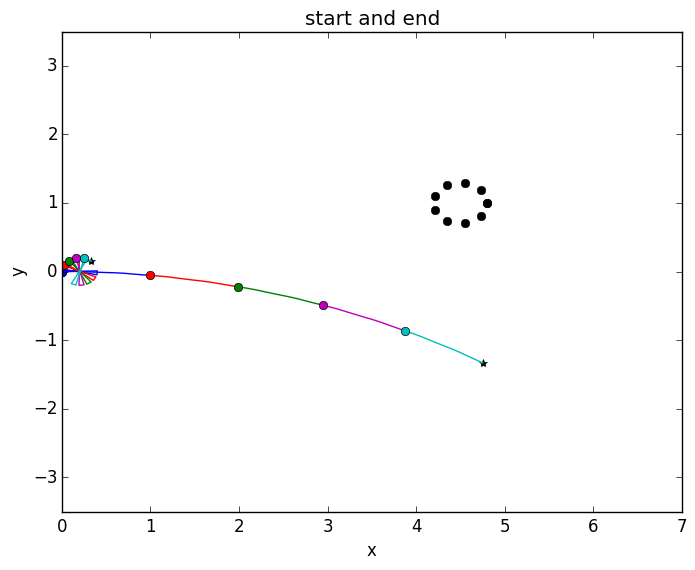

(-3.5,3.5)

In [60]:
(p,e)=ccArm2(traj[1, :])
drawArm(p, e)

(p,e)=ccArm2(traj[end, :])
drawArm(p, e)


drawZone(goal)
title("start and end")
xlabel("x")
ylabel("y")
xlim(-0, 7)
ylim(-3.5, 3.5)


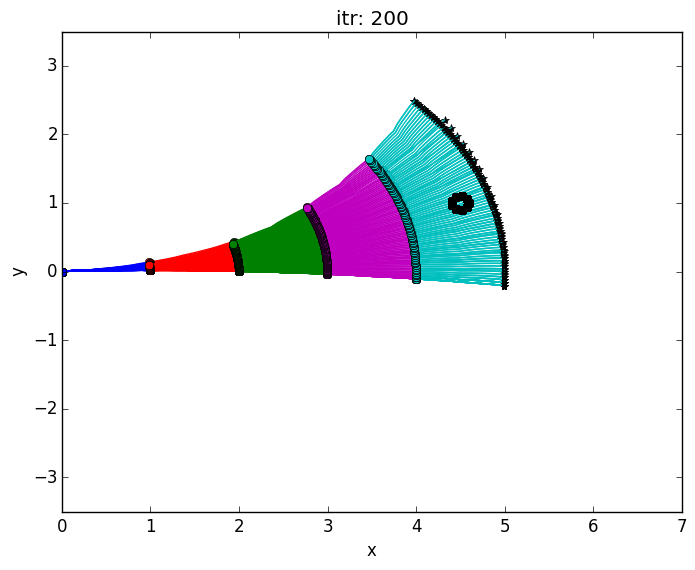

In [43]:
hold("on")
scale=10
for i=1:nsteps
    if i%(nsteps/scale)==0
        (p,e)=ccArm2(traj[i, :])
        drawArm(p, e)
        drawZone(goal)
        title("itr: $(i)")
        xlabel("x")
        ylabel("y")
        xlim(-0, 7)
        ylim(-3.5, 3.5)
    end
end


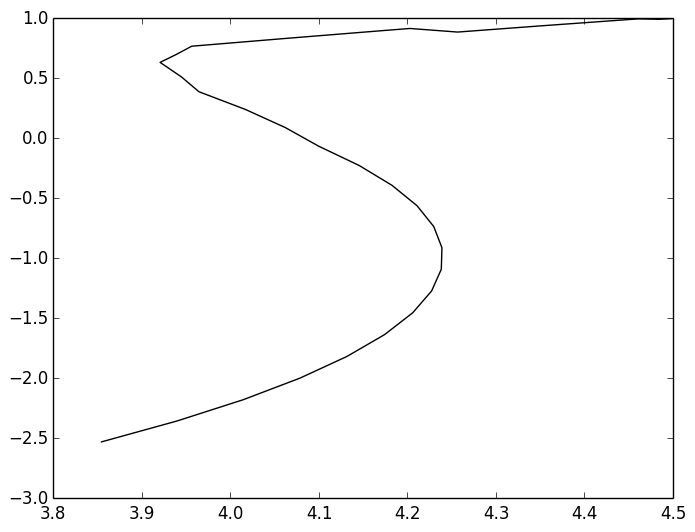

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x11bdd4150>

In [26]:
using PyPlot
plot(p[:,1], p[:,2], "k")